1. Com base no dataset de empre stimos (loan.csv) disponível em:
https://github.com/josenalde/machinelearning/blob/main/src/dataset/loan.csv,
desenvolver modelo de aprendizagem de ma quina para classificação binária de
liberação de empréstimo. Sugere-se as etapas seguintes, mas não restritas a estas:

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn
from joblib import dump
from sklearn.svm import SVC
import matplotlib.pyplot as plt
from sklearn.utils import resample
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import classification_report, roc_auc_score, roc_curve

print(sklearn.__version__)

1.5.1


a) Verificar o balanceamento das classes da variável alvo (‘loan_status’) e balancear
se necessário

In [2]:
# Pegar o arquivo csv direto do github
db = pd.read_csv("https://raw.githubusercontent.com/josenalde/machinelearning/refs/heads/main/src/dataset/loan.csv")
df = db.copy()
#Exibir Informações do database
df.head()


,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            614 non-null    object 
 1   Gender             601 non-null    object 
 2   Married            611 non-null    object 
 3   Dependents         599 non-null    object 
 4   Education          614 non-null    object 
 5   Self_Employed      582 non-null    object 
 6   ApplicantIncome    614 non-null    int64  
 7   CoapplicantIncome  614 non-null    float64
 8   LoanAmount         592 non-null    float64
 9   Loan_Amount_Term   600 non-null    float64
 10  Credit_History     564 non-null    float64
 11  Property_Area      614 non-null    object 
 12  Loan_Status        614 non-null    object 
dtypes: float64(4), int64(1), object(8)
memory usage: 62.5+ KB


In [4]:

# Realizar downsampling da quantidade maior
df_majority = df[df["Loan_Status"] == 'Y']
df_minority = df[df["Loan_Status"] == 'N']

#422 - sim e 192 - não

#usando o resample
df_majority_downsampled = resample(
    df_majority,
    replace = False,
    n_samples = len(df_minority),
    random_state = 42
)

df_balanced = pd.concat([df_majority_downsampled, df_minority])

df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)
# Verificar o balanceamento
df_balanced["Loan_Status"].value_counts() #192 - sim e 192 - não

# # Aplicando o downsampling
# classe_y_downsampled = classe_y.sample(n=len(classe_n), random_state=42)

# # Concatenando as classes
# df_balanceado = pd.concat([classe_y_downsampled, classe_n])

# # Embaralhando o DataFrame
# df_balanceado = df_balanceado.sample(frac=1, random_state=42).reset_index(drop=True)

# df_balanceado['Loan_Status'].value_counts()

Loan_Status
N    192
Y    192
Name: count, dtype: int64

In [5]:
# Verificar o balanceamento
df["Loan_Status"].value_counts() #192 - sim e 192 - não

Loan_Status
Y    422
N    192
Name: count, dtype: int64

b) Remover as colunas loan_id, coapplicantincome, loan_amount_term,
credit_history, property_area


In [6]:
# Criando um dataset onde serão feitas as modificações
#Comentar a primeira linha para umt treino com os dados desbalanceados, Segunda linha para dados balanceados.
df_modified = df_balanced.drop(columns=["Loan_ID", "CoapplicantIncome", "Loan_Amount_Term", "Credit_History", "Property_Area"])
#df_modified = df.drop(columns=["Loan_ID", "CoapplicantIncome", "Loan_Amount_Term", "Credit_History", "Property_Area"])

# Mostrando as colunas do novo dataset
df_modified.head()

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,LoanAmount,Loan_Status
0,Male,Yes,0,Graduate,NaN,5746,255.0,N
1,Male,No,0,Not Graduate,No,2333,102.0,N
2,Male,No,0,Graduate,No,4680,NaN,N
3,Male,Yes,2,Not Graduate,No,2309,125.0,N
4,Female,No,0,Graduate,No,4547,115.0,Y


c) Verificar dados faltantes e preencher conforme sugestão:
c.1) dependents (dependentes), self_employed (auto nomo), married
(Casado?), gender (Sexo): preencher com valor majorita rio da respectiva coluna (moda)

In [7]:
#Verificando se há dados faltantes.
df_modified.isnull().sum()

Gender              7
Married             1
Dependents          9
Education           0
Self_Employed      20
ApplicantIncome     0
LoanAmount         16
Loan_Status         0
dtype: int64

In [8]:
#Preencher dados faltantes por coluna
cols_to_fill = ['Dependents', 'Self_Employed', 'Married', 'Gender', 'LoanAmount']
for col in cols_to_fill:
    df_modified[col] = df_modified[col].fillna(df_modified[col].mode()[0])

d) Confirmar se na o ha dados faltantes

In [9]:
#Confirmando que não há mais dados faltantes.
df_modified.isnull().sum()

Gender             0
Married            0
Dependents         0
Education          0
Self_Employed      0
ApplicantIncome    0
LoanAmount         0
Loan_Status        0
dtype: int64

e) Transformar features catego ricas: gender, married, education, self_employed,
bem como a varia vel target. Verificar quando e melhor LabelEncoder ou
OneHotEncoder

In [10]:

#atribuindo o LabelEncoder
encoder = LabelEncoder()

# Usando o encoder nas colunas
cols_to_encode = ['Gender', 'Married', 'Education', 'Self_Employed', 'Loan_Status']
for col in cols_to_encode:
    df_modified[col] = encoder.fit_transform(df_modified[col])

#mostrando as colunas
df_modified.head()
#Gender: Male = 1, Female = 0
#Married: Yes = 1 , No = 0
#Education: Not Graduate = 1, Graduate = 0
#Self_Employed: Yes = 1, No = 0
#Loan_Status: Y = 1, N = 0

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,LoanAmount,Loan_Status
0,1,1,0,0,0,5746,255.0,0
1,1,0,0,1,0,2333,102.0,0
2,1,0,0,0,0,4680,120.0,0
3,1,1,2,1,0,2309,125.0,0
4,0,0,0,0,0,4547,115.0,1


f) No caso da feature dependents, para o caso 3+ associar ao rótulo de número 3. Os
demais números de dependentes esta o ok: 0,1,2

In [11]:
#modificando o valor de '3+' para '3'
df_modified['Dependents'] = df_modified['Dependents'].replace('3+', 3).astype(int)

#vendo se foram modificados
df_modified

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,LoanAmount,Loan_Status
0,1,1,0,0,0,5746,255.0,0
1,1,0,0,1,0,2333,102.0,0
2,1,0,0,0,0,4680,120.0,0
3,1,1,2,1,0,2309,125.0,0
4,0,0,0,0,0,4547,115.0,1
...,...,...,...,...,...,...,...,...
379,0,1,1,0,0,3326,105.0,1
380,0,0,2,0,0,3750,120.0,1
381,1,0,0,0,1,6050,120.0,0
382,1,0,0,0,0,3583,96.0,0


g) Transformar features nume ricas com padronizaça o (standard scaler)

In [12]:

#atribuindo o scaler
scaler = StandardScaler(with_std=True, with_mean=False)

numerical_columns = ['Dependents', 'ApplicantIncome', 'LoanAmount']

df_modified[numerical_columns] = scaler.fit_transform(df_modified[numerical_columns])

# Salvar o scaler utilizado no treinamento
dump(scaler, "scaler.pkl")
print("Scaler salvo como 'scaler.pkl'")

df_modified.head()

Scaler salvo como 'scaler.pkl'


,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,LoanAmount,Loan_Status
0,1,1,0.00000,0,0,0.938906,2.995710,0
1,1,0,0.00000,1,0,0.381216,1.198284,0
2,1,0,0.00000,0,0,0.764720,1.409746,0
3,1,1,1.95231,1,0,0.377294,1.468485,0
4,0,0,0.00000,0,0,0.742987,1.351006,1


h) Criar 5 Pipelines de transformaço es e treino para 5 algoritmos diferentes de
classificaça o, com Grid Search e validaça o cruzada, comparando as me tricas de
desempenho (classification_report) e AUC da curva ROC.

In [13]:
X = df_modified.drop('Loan_Status', axis=1)
y = df_modified['Loan_Status']

def model_val(model, X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    model.fit(X_train, y_train)
    y_predict = model.predict(X_test)
    print(f"{model}  AUC = {roc_auc_score(y_test, y_predict)}")
    score = cross_val_score(model, X, y, cv=5, scoring='roc_auc')

Treinando modelo: Logistic Regression
Logistic Regression - AUC: 0.4283154121863799

Treinando modelo: Random Forest
Random Forest - AUC: 1.0

Treinando modelo: Gradient Boosting
Gradient Boosting - AUC: 0.9840203106332139

Treinando modelo: Decision Tree
Decision Tree - AUC: 0.9768518518518519

Treinando modelo: KNN
KNN - AUC: 0.8297491039426523

{'memory': None, 'steps': [('imputer', SimpleImputer(strategy='most_frequent')), ('scaler', StandardScaler()), ('pca', PCA(n_components=2)), ('classifier', KNeighborsClassifier())], 'verbose': False, 'imputer': SimpleImputer(strategy='most_frequent'), 'scaler': StandardScaler(), 'pca': PCA(n_components=2), 'classifier': KNeighborsClassifier(), 'imputer__add_indicator': False, 'imputer__copy': True, 'imputer__fill_value': None, 'imputer__keep_empty_features': False, 'imputer__missing_values': nan, 'imputer__strategy': 'most_frequent', 'scaler__copy': True, 'scaler__with_mean': True, 'scaler__with_std': True, 'pca__copy': True, 'pca__iterated_p

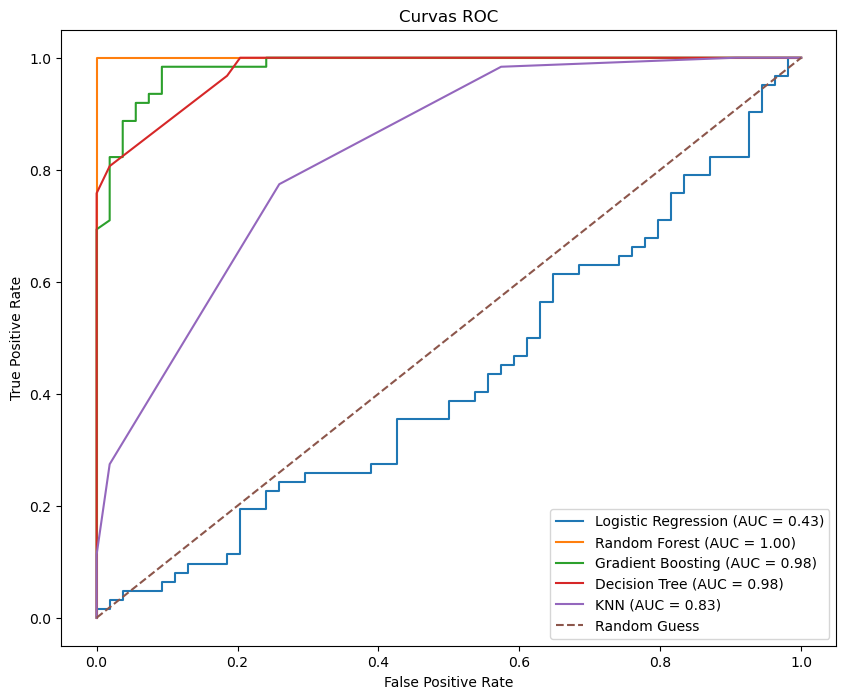


Resultados das AUCs:
Logistic Regression: AUC = 0.4283
Random Forest: AUC = 1.0000
Gradient Boosting: AUC = 0.9840
Decision Tree: AUC = 0.9769
KNN: AUC = 0.8297


In [14]:
pipelines = {
    'Logistic Regression': Pipeline([
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('scaler', StandardScaler()),
        ('pca', PCA(n_components=2)),
        ('classifier', LogisticRegression())
    ]),
    'Random Forest': Pipeline([
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('scaler', StandardScaler()),
        ('pca', PCA(n_components=2)),
        ('classifier', RandomForestClassifier())
    ]),
    'Gradient Boosting': Pipeline([
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('scaler', StandardScaler()),
        ('pca', PCA(n_components=2)),
        ('classifier', GradientBoostingClassifier())
    ]),
    'Decision Tree': Pipeline([
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('scaler', StandardScaler()),
        ('pca', PCA(n_components=2)),
        ('classifier', DecisionTreeClassifier())
    ]),
    'KNN': Pipeline([
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('scaler', StandardScaler()),
        ('pca', PCA(n_components=2)),
        ('classifier', KNeighborsClassifier())
    ])
}

# Definição de grades de parâmetros para cada modelo
param_grids = {
    'Logistic Regression': {
        'classifier__C': [0.1, 1, 10],
        'classifier__penalty': ['l2']
    },
    'Random Forest': {
        'classifier__n_estimators': [100, 200],
        'classifier__max_depth': [5, 10, None]
    },
    'Gradient Boosting': {
        'classifier__n_estimators': [100, 200],
        'classifier__learning_rate': [0.05, 0.1, 0.2]
    },
    'Decision Tree': {
        'classifier__max_depth': [5, 10, None],
        'classifier__min_samples_split': [2, 5, 10],
        'classifier__min_samples_leaf': [1, 2, 4]
    },
    'KNN': {
        'classifier__n_neighbors': [3, 5, 7],
        'classifier__weights': ['uniform', 'distance']
    }
}

# armazenando os resultados das AUCs
auc_scores = {}
best_model_name = ""
best_auc = 0
best_pipeline = None
# modelos e seleção do melhor com base na AUC
plt.figure(figsize=(10, 8))
for name, pipeline in pipelines.items():
    print(f"Treinando modelo: {name}")
    grid_search = GridSearchCV(pipeline, param_grids[name], cv=5, n_jobs=-1, scoring='roc_auc')
    grid_search.fit(X, y)
    best_model = grid_search.best_estimator_

    # divisão do conjunto de teste e treino
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    y_prob = best_model.predict_proba(X_test)[:, 1]

    # calcular AUC
    auc = roc_auc_score(y_test, y_prob)
    auc_scores[name] = auc
    print(f"{name} - AUC: {auc}\n")

    # pegar o melhor modelo
    if auc > best_auc :
        best_auc = auc
        best_model_name = name
        best_pipeline = best_model

    # curva ROC
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {auc:.2f})')

print(best_model.get_params())
# curva ROC geral
plt.plot([0, 1], [0, 1], linestyle='--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curvas ROC')
plt.legend()
plt.show()

# Exibir os AUCs de todos os modelos
print("\nResultados das AUCs:")
for model, auc in auc_scores.items():
    print(f"{model}: AUC = {auc:.4f}")


i) Escolha o modelo final e salve o respectivo Pipeline apenas com o fit do
best_estimator_, pois na aplicaça o sera feito apenas o predict


In [15]:
# Salvar apenas o pipeline ajustado do melhor modelo
if best_pipeline:
    dump(best_pipeline, "modelo_final.pkl")
    print(f"Pipeline salvo como 'modelo_final.pkl'. Melhor modelo: {best_model_name} com AUC = {best_auc:.2f}")

Pipeline salvo como 'modelo_final.pkl'. Melhor modelo: Random Forest com AUC = 1.00


OBS.: Percebesse que ao Não balancear os dados, Random Forest, Gradient Boosting e Decision Tree(Modelo que mais varia AUC)
todos eles variam na faixa de ≈86%, porém ao balancear os dados, Random Forest e Gradient Boosting sobem a AUC para ≈100% (Principalmente Random Forest).